In [1]:
# Essentials
%load_ext google.cloud.bigquery
import pandas as pd
from itertools import product
from collections import Counter
import datetime as dt
from dateutil.relativedelta import relativedelta


# plots
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# "Will it snow tomorrow?" - The time traveler asked
> The following dataset contains climate information form over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 13 years ago. So if today is 2022.02.15 then the weather we want to forecast is for the date 2009.02.16. You are suppsed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to used BigQuery in Jupyter Notebook refer to the Google Docs. 

> The goal of this test is, to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck at the first part, you can use the replacement data provided in the second part

In [2]:
%%bigquery temp
SELECT
    *,
FROM 
    `bigquery-public-data.samples.gsod`
LIMIT 20

Downloading: 100%|██████████| 20/20 [00:01<00:00, 10.25rows/s]


In [3]:
temp # view data

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,36010,99999,1929,11,14,42.000000,4,40.200001,4.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
1,37950,99999,1929,12,28,39.700001,4,38.299999,4.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
2,38560,99999,1930,6,29,58.500000,4,NaN,NaN,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
3,39730,99999,1930,5,26,54.000000,4,49.000000,4.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
4,36010,99999,1930,4,28,53.700001,4,NaN,NaN,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
5,39530,99999,1931,3,18,50.799999,4,47.400002,4.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False
6,38640,99999,1931,5,17,51.500000,4,46.900002,4.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
7,726810,24131,1931,9,4,79.900002,24,39.000000,8.0,NaN,...,NaN,None,0.0,NaN,False,False,False,False,False,False
8,726810,24131,1931,12,2,18.500000,24,13.800000,8.0,NaN,...,NaN,None,0.0,NaN,True,True,True,True,True,True
9,726810,24131,1931,11,8,54.799999,24,32.200001,8.0,NaN,...,NaN,None,NaN,NaN,False,False,False,False,False,False


## Part 1

### 1. Task
> Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [4]:
# Get column names for query
# print(*temp, sep=',\n')

Note: We assume "2005 till 2009"means including 2009.

In [5]:
%%bigquery all_data
SELECT
    station_number,
    wban_number,
    mean_temp,
    num_mean_temp_samples,
    mean_dew_point,
    num_mean_dew_point_samples,
    mean_sealevel_pressure,
    num_mean_sealevel_pressure_samples,
    mean_station_pressure,
    num_mean_station_pressure_samples,
    mean_visibility,
    num_mean_visibility_samples,
    mean_wind_speed,
    num_mean_wind_speed_samples,
    max_sustained_wind_speed,
    max_gust_wind_speed,
    max_temperature,
    max_temperature_explicit,
    min_temperature,
    min_temperature_explicit,
    total_precipitation,
    snow_depth,
    fog,
    rain,
    snow,
    hail,
    thunder,
    tornado,
DATE(year, month, day) AS date,
FROM 
    `bigquery-public-data.samples.gsod`
WHERE 
    year BETWEEN 2005 AND 2009 AND
    station_number BETWEEN 725300 AND 726300

Downloading: 100%|██████████| 377784/377784 [00:37<00:00, 10167.32rows/s]


In [6]:
all_data.head()

,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
0,725869,99999,58.099998,4,51.799999,4.0,NaN,NaN,NaN,NaN,...,None,0.15,NaN,False,False,False,False,False,False,2005-08-18
1,726056,99999,34.900002,5,19.400000,5.0,NaN,NaN,NaN,NaN,...,None,0.00,NaN,False,False,False,False,False,False,2005-12-11
2,725868,99999,32.000000,6,31.400000,6.0,NaN,NaN,NaN,NaN,...,None,0.10,NaN,False,False,False,False,False,False,2005-03-29
3,725835,99999,88.699997,6,32.000000,6.0,NaN,NaN,NaN,NaN,...,None,0.00,NaN,False,False,False,False,False,False,2005-07-02
4,725868,99999,24.000000,7,18.600000,7.0,NaN,NaN,NaN,NaN,...,None,0.00,15.0,True,True,True,True,True,True,2005-02-22


### 2. Task 
> From here want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

In [7]:
# all_data.info()
subset_df = all_data # Keep original dataset intact to avoid re-executing the query

subset_df['date'] = pd.to_datetime(subset_df['date']).dt.normalize() # Convert date column to pandas datetime

# We use variables for subsetting for potential automation
min_date = '2005-01-01'
max_date = '2009-12-31'
min_station_number = 725300
max_station_number = 725330

subset_df = subset_df[(subset_df['date'] >= min_date) & (subset_df['date'] <= max_date)]
subset_df = subset_df[(subset_df['station_number'] >= min_station_number) & (subset_df['station_number'] <= max_station_number)]

Let's have a look at the summary of our data.

In [8]:
subset_df.describe(datetime_is_numeric=True, include='all')

,station_number,wban_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_station_pressure,num_mean_station_pressure_samples,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
count,18129.000000,18129.000000,18129.000000,18129.000000,18127.000000,18127.000000,16291.000000,16291.000000,993.000000,993.000000,...,0,17938.000000,565.000000,18129,18129,18129,18129,18129,18129,18129
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,2,2,2,2,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15987,15987,15987,15987,15987,15987,NaN
mean,725316.962050,72766.474488,51.999636,23.574163,41.605108,23.553704,1016.937585,21.682217,990.766767,23.309164,...,NaN,0.095488,2.865133,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-02 19:52:01.032599808
min,725300.000000,3887.000000,-16.200001,4.000000,-23.500000,4.000000,985.299988,4.000000,967.599976,4.000000,...,NaN,0.000000,1.200000,NaN,NaN,NaN,NaN,NaN,NaN,2005-01-01 00:00:00
25%,725314.000000,14842.000000,36.299999,24.000000,27.500000,24.000000,1012.799988,20.000000,986.400024,24.000000,...,NaN,0.000000,1.200000,NaN,NaN,NaN,NaN,NaN,NaN,2006-04-01 00:00:00
50%,725316.000000,99999.000000,53.799999,24.000000,42.599998,24.000000,1016.700012,23.000000,990.700012,24.000000,...,NaN,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,2007-07-03 00:00:00
75%,725326.000000,99999.000000,69.099998,24.000000,57.200001,24.000000,1020.900024,24.000000,995.000000,24.000000,...,NaN,0.040000,3.900000,NaN,NaN,NaN,NaN,NaN,NaN,2008-10-01 00:00:00
max,725330.000000,99999.000000,92.000000,24.000000,79.099998,24.000000,1044.199951,24.000000,1017.099976,24.000000,...,NaN,9.990000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-31 00:00:00


> Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

#### Visualize missing data

In the first plot we visualize the missing data with a cumulative bar for each variable. On the second graph, we visualize the missing data in their actual location in the dataset.

<AxesSubplot:>

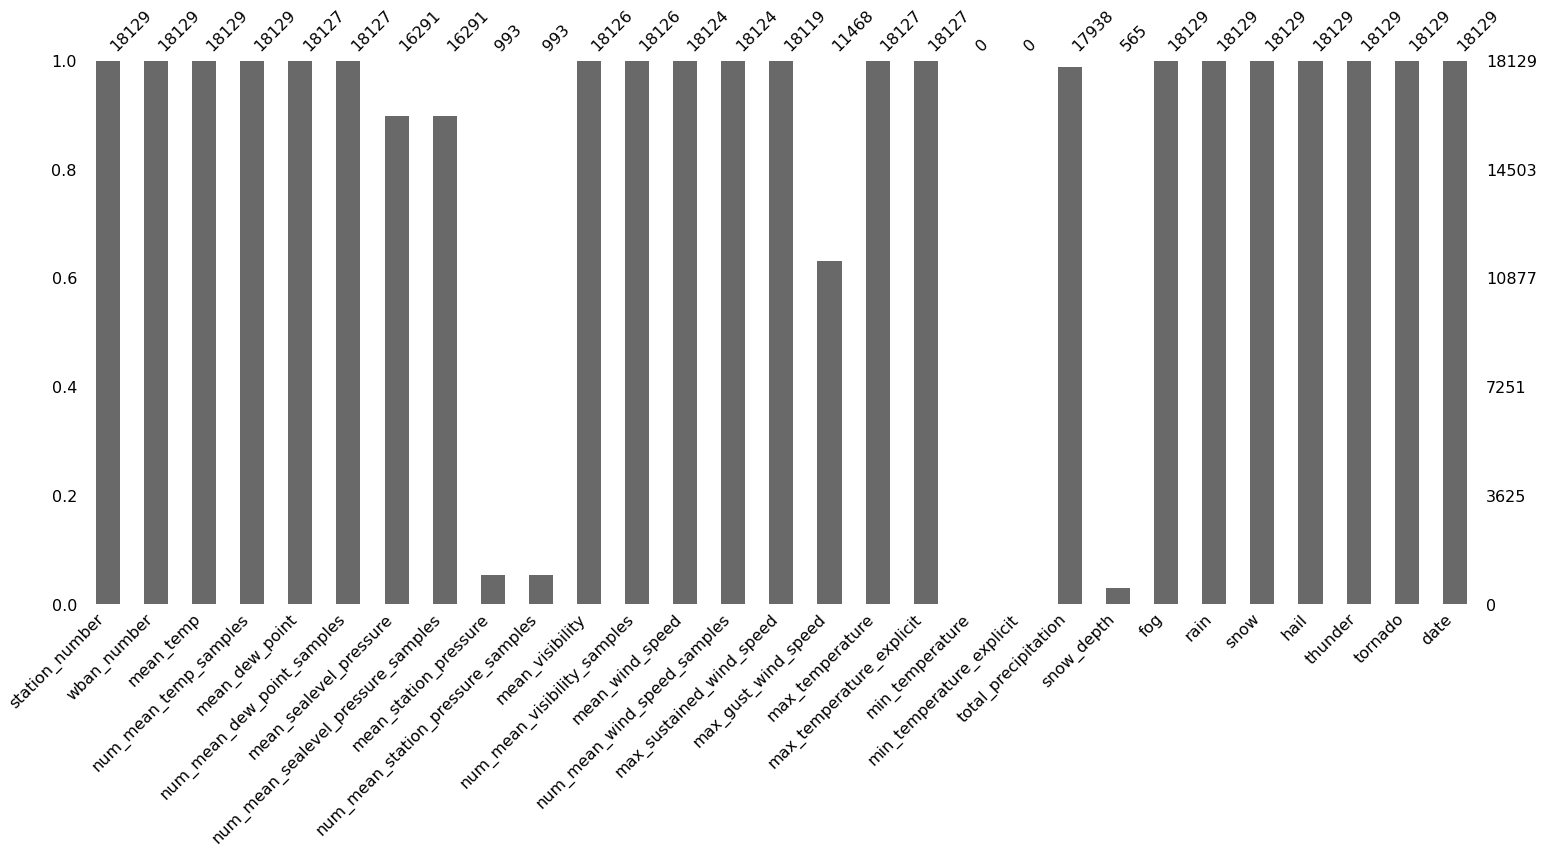

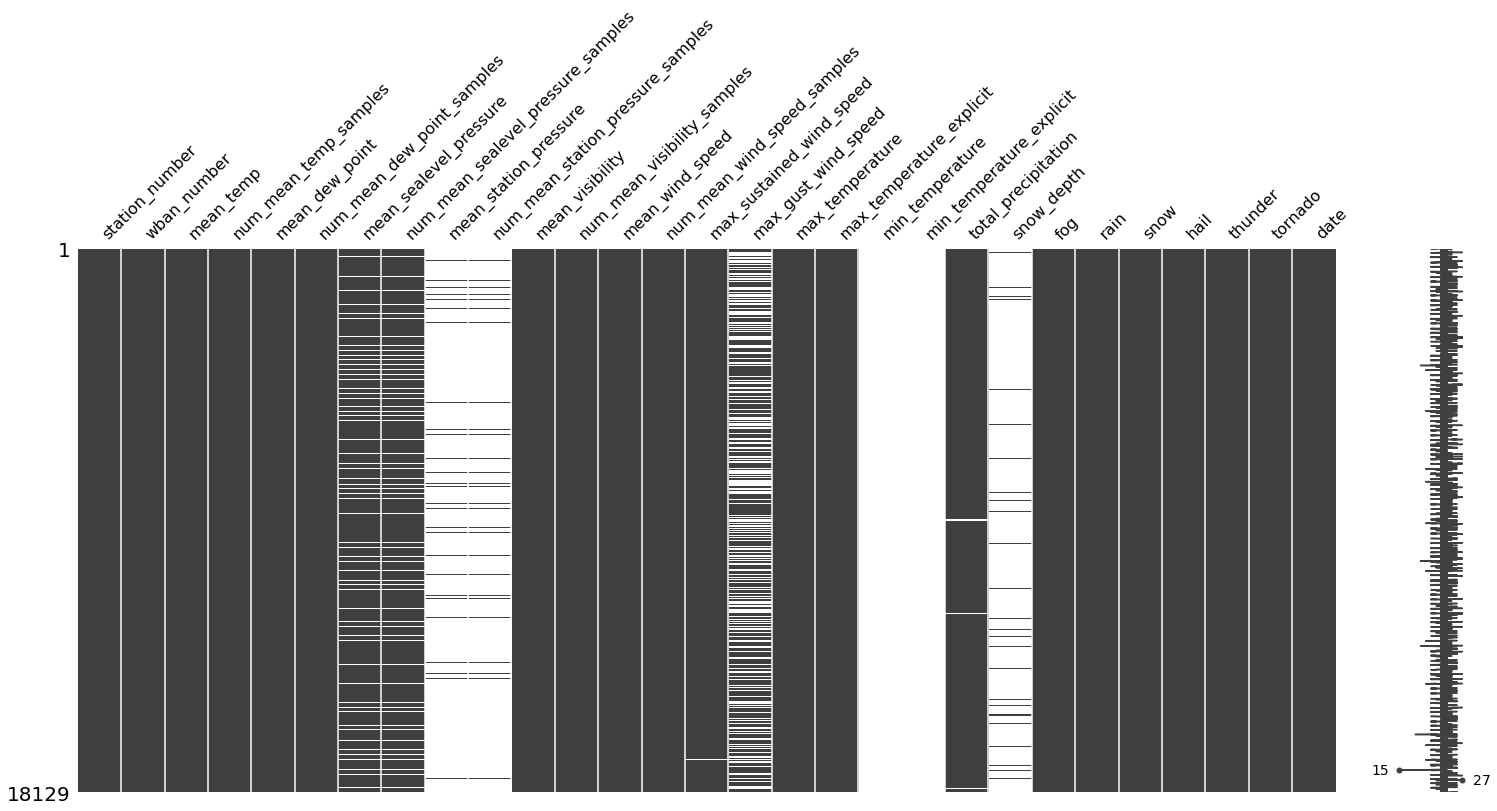

In [9]:
msno.bar(subset_df)
msno.matrix(subset_df)
# msno.heatmap(subset_df)

We see some columns are completely empty and some others barely contain any data. We can safely drop these variables since they don't offer any predictive value to our model.
We see that the columns `min_temperature` and `min_temperature_explicit` are completely empty. Furthermore, the columns `mean_station_pressure`,`num_mean_station_pressure_samples` contain barely any data. In addition, we can drop the wban_number since it just represents a [different station numbering scheme](https://www.ncei.noaa.gov/access/homr/reports/platforms#:~:text=WBAN%20numbers%20were,is%20updated%20monthly.). We also drop `max_gust_wind_speed` since it contains many missing values and we already have a couple of variables related to wind.

Furthermore, we see below that the `snow_depth` variable is completely missing except for three stations. Therefore we remove the column and possibly revisit it in another model which incorporates only the three stations.

In [10]:
temp1 = subset_df.groupby(['station_number','snow'])
temp1['snow_depth'].describe()

count      mean       std  min  25%  50%  75%   max
station_number snow                                                      
725300         False  205.0  3.135610  2.235597  1.2  1.2  2.0  5.1  11.0
               True    84.0  3.796429  2.468278  1.2  1.2  3.5  5.1  11.8
725305         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725314         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725315         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725316         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725317         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725320         False    7.0  1.200000  0.000000  1.2  1.2  1.2  1.2   1.2
               True    14.0  1.257143  0.213809  1.2  1.2  1.2  1.2   2.0
725326         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725327         False    0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
               True     0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN
725330         False  162.0  2.298148  1.485435  1.2  1.2  2.0  3.1   7.9
               True    93.0  2.782796  2.146667  1.2  1.2  2.0  3.9  13.0

In [11]:
subset_df = subset_df.drop(columns=['mean_station_pressure','num_mean_station_pressure_samples','min_temperature','min_temperature_explicit','wban_number','max_gust_wind_speed','snow_depth'])

Let's see how our dataset looks now.

In [12]:
subset_df.head(3)

,station_number,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,num_mean_sealevel_pressure_samples,mean_visibility,num_mean_visibility_samples,mean_wind_speed,...,max_temperature,max_temperature_explicit,total_precipitation,fog,rain,snow,hail,thunder,tornado,date
103,725326,17.400000,24,8.100000,24.0,NaN,NaN,9.9,24.0,8.6,...,10.400000,True,0.0,False,False,False,False,False,False,2005-01-28
113,725326,35.000000,24,31.900000,24.0,NaN,NaN,3.1,24.0,1.4,...,33.799999,False,0.0,False,False,False,False,False,False,2005-12-24
187,725326,69.400002,24,51.599998,24.0,NaN,NaN,9.6,24.0,9.7,...,55.400002,True,0.0,False,False,False,False,False,False,2005-05-10


Next, we notice that there are a couple missing rows/dates missing for some stations.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Make a date index from the complete date range
date_index = pd.date_range(subset_df['date'].min(), subset_df['date'].max())
        
print('Missing dates per station\n')
for key, group in subset_df.groupby(['station_number']):
    print(f'Station {key}: Temperature: {len(date_index) - len(group.mean_temp)} Precipitation: {len(date_index) - len(group.total_precipitation)} Snow: {len(date_index) - len(group.snow)}')


Missing dates per station

Station 725300: Temperature: 4 Precipitation: 4 Snow: 4
Station 725305: Temperature: 2 Precipitation: 2 Snow: 2
Station 725314: Temperature: 26 Precipitation: 26 Snow: 26
Station 725315: Temperature: 2 Precipitation: 2 Snow: 2
Station 725316: Temperature: 2 Precipitation: 2 Snow: 2
Station 725317: Temperature: 4 Precipitation: 4 Snow: 4
Station 725320: Temperature: 2 Precipitation: 2 Snow: 2
Station 725326: Temperature: 41 Precipitation: 41 Snow: 41
Station 725327: Temperature: 45 Precipitation: 45 Snow: 45
Station 725330: Temperature: 3 Precipitation: 3 Snow: 3


We also notice that the missing data is not in continuous periods, but it is only missing sporadically. In combination with the relatively small number of missing dates per station, we can interpolate the data for the missing dates from the previous dates.

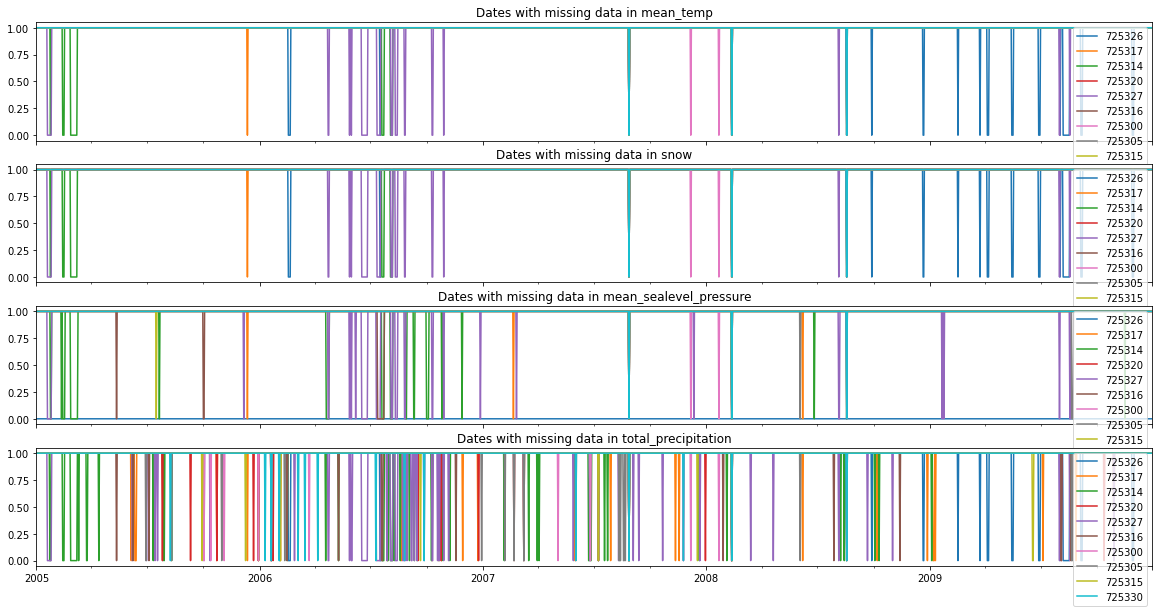

In [14]:
def plot_missing_data(column, axis, subset_df):
    dates = pd.DataFrame(columns=[station for station in subset_df['station_number'].unique()], 
                         index=date_index, data=0)
    for key, group in subset_df.groupby(['station_number']):
        dates_with_not_NA_mean_temp = subset_df[~subset_df[column].isna()][subset_df['station_number']==key]
        dates.loc[dates_with_not_NA_mean_temp['date'].values, key] = 1
    dates.plot(ax=axis)
    axis.set_title(f'Dates with missing data in {column}')
    
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(20, 10))

plot_missing_data('mean_temp', axes[0], subset_df)
plot_missing_data('snow', axes[1], subset_df)
plot_missing_data('mean_sealevel_pressure', axes[2], subset_df)
plot_missing_data('total_precipitation', axes[3], subset_df)

Before we continue to the interpolation, let's have a more detailed look at what our data actully is. We can do this 
by looking for the data description such as this [readme file](https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt) from the NOAA website, or better yet in the metadata of our dataset as can be seen below.

In [15]:
%%bigquery temp2
SELECT
 column_name, description
FROM 
  `bigquery-public-data.samples`.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
WHERE
  table_name = 'gsod'

Downloading: 100%|██████████| 31/31 [00:02<00:00, 10.89rows/s]


In [16]:
pd.set_option('display.max_colwidth', None)
temp2 = temp2.style.set_properties(**{'text-align': 'left'})
temp2
# pd.reset_option('max_colwidth')

,column_name,description
0,station_number,The World Meteorological Organization (WMO) / DATSAV3 station number where the data was collected.
1,wban_number,The Weather-Bureau-Army-Navy (WBAN) station number where the data was collected.
2,year,The year the data was collected in
3,month,The month the data was collected in
4,day,The day the data was collected in.
5,mean_temp,"The mean temperature of the day in degrees Fahrenheit, accurate to one tenth of a degree."
6,num_mean_temp_samples,The number of observations used to calculate mean_temp.
7,mean_dew_point,"The mean dew point of the day in degrees Fahrenheit, accurate to one tenth of a degree."
8,num_mean_dew_point_samples,The number of observations used to calculate mean_dew_point.
9,mean_sealevel_pressure,"The mean sea level pressure of the day in millibars, accurate to one tenth of a millibar"


We notice that there are multiple columns that are not of much use regarding the predictive value, such as the column names with suffix `_samples`, which represent the number of observations used to calculate the mean of a daily measurement. These could be useful as weights for the measures to emphasize more accurate measurements, but for now we will drop them.
The same stands for the variables with the suffix `_explicit`, which indicate for example if the `max_temperature` is actually the maximum temperature of that day or if it is the maximum measurement from the hourly data. We can safely drop them for now.

In [17]:
subset_df = subset_df.loc[:, ~subset_df.columns.str.contains('_samples')]
subset_df = subset_df.loc[:, ~subset_df.columns.str.contains('_explicit')]

We reindex the dataframe with a multi-index to have the series grouped by station.

In [18]:
# Reindex on station_number and date to get continuous time series.
data_reindexed = subset_df.set_index(['station_number', 'date']).reindex(pd.MultiIndex.from_product(
        [subset_df['station_number'].unique(), date_index],
        names=['station_number', 'date']))

In [19]:
data_reindexed

mean_temp  mean_dew_point  mean_sealevel_pressure  \
station_number date                                                            
725326         2005-01-01  29.400000       20.100000                     NaN   
               2005-01-02  38.700001       35.200001                     NaN   
               2005-01-03  31.799999       28.200001                     NaN   
               2005-01-04  28.799999       25.799999                     NaN   
               2005-01-05  24.700001       20.799999                     NaN   
...                              ...             ...                     ...   
725330         2009-12-27  26.799999       21.299999             1012.099976   
               2009-12-28  21.799999       18.299999             1014.099976   
               2009-12-29  25.500000       16.500000             1028.000000   
               2009-12-30  23.200001       16.500000             1026.099976   
               2009-12-31  33.299999       30.600000             1015.700012   

                           mean_visibility  mean_wind_speed  \
station_number date                                           
725326         2005-01-01             10.0              9.7   
               2005-01-02              6.9              8.0   
               2005-01-03              7.3              5.5   
               2005-01-04              6.3              6.1   
               2005-01-05              4.8             11.1   
...                                    ...              ...   
725330         2009-12-27              5.0              8.0   
               2009-12-28              6.3             14.2   
               2009-12-29              9.9              5.8   
               2009-12-30              9.4              5.3   
               2009-12-31              4.4              8.1   

                           max_sustained_wind_speed  max_temperature  \
station_number date                                                    
725326         2005-01-01                      18.1        21.200001   
               2005-01-02                      16.9        32.000000   
               2005-01-03                      12.0        28.400000   
               2005-01-04                      11.1        28.400000   
               2005-01-05                      16.9        21.200001   
...                                             ...              ...   
725330         2009-12-27                      21.0        21.200001   
               2009-12-28                      22.9        17.100000   
               2009-12-29                      16.9        18.000000   
               2009-12-30                      11.1        14.000000   
               2009-12-31                      15.0        30.000000   

                           total_precipitation    fog   rain   snow   hail  \
station_number date                                                          
725326         2005-01-01                 0.00  False  False  False  False   
               2005-01-02                 0.44  False  False  False  False   
               2005-01-03                 0.11  False  False  False  False   
               2005-01-04                 0.24  False  False  False  False   
               2005-01-05                 0.01  False  False  False  False   
...                                        ...    ...    ...    ...    ...   
725330         2009-12-27                 0.00   True   True   True   True   
               2009-12-28                 0.14  False  False  False  False   
               2009-12-29                 0.00  False  False  False  False   
               2009-12-30                 0.01  False  False  False  False   
               2009-12-31                 0.11  False  False  False  False   

                          thunder tornado  
station_number date                        
725326         2005-01-01   False   False  
               2005-01-02   False   False  
               2005-01-03   False   Fa

The reindexing caused some additional missing values for the dates that were missing in some stations.

In [20]:
data_reindexed.isna().sum()

mean_temp                    131
mean_dew_point               133
mean_sealevel_pressure      1969
mean_visibility              134
mean_wind_speed              136
max_sustained_wind_speed     141
max_temperature              133
total_precipitation          322
fog                          131
rain                         131
snow                         131
hail                         131
thunder                      131
tornado                      131
dtype: int64

We interpolate the continuous variables and for the boolean variables we use the value of the previous day. This will increase the autocorrelation but will not skew our data. Clearly this process will affect the model so other techniques should also be explored, eg. Kalman filter. 

For the `mean_sealevel_pressure` we use `limit_direction='both'` as a method to fill consecutive NaNs in both directions. We could also impute this with the mean since the distribution is relatively normal.

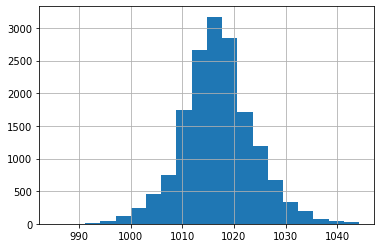

In [21]:
subset_df['mean_sealevel_pressure'].hist(bins=20);

In [22]:
data_reindexed['mean_temp'] = data_reindexed['mean_temp'].interpolate()
data_reindexed['mean_dew_point'] = data_reindexed['mean_dew_point'].interpolate()
data_reindexed['mean_sealevel_pressure'] = data_reindexed['mean_sealevel_pressure'].interpolate(limit_direction='both')
data_reindexed['mean_visibility'] = data_reindexed['mean_visibility'].interpolate()
data_reindexed['mean_wind_speed'] = data_reindexed['mean_wind_speed'].interpolate()
data_reindexed['max_sustained_wind_speed'] = data_reindexed['max_sustained_wind_speed'].interpolate()
data_reindexed['max_temperature'] = data_reindexed['max_temperature'].interpolate()
data_reindexed['total_precipitation'] = data_reindexed['total_precipitation'].interpolate()

data_reindexed['fog'] = data_reindexed['fog'].fillna(method='ffill')
data_reindexed['rain'] = data_reindexed['rain'].fillna(method='ffill')
data_reindexed['snow'] = data_reindexed['snow'].fillna(method='ffill')
data_reindexed['hail'] = data_reindexed['hail'].fillna(method='ffill')
data_reindexed['thunder'] = data_reindexed['thunder'].fillna(method='ffill')
data_reindexed['tornado'] = data_reindexed['tornado'].fillna(method='ffill')

We take a look again at our data and make sure that the count for each variable is the same.

In [23]:
data_reindexed.describe()

,mean_temp,mean_dew_point,mean_sealevel_pressure,mean_visibility,mean_wind_speed,max_sustained_wind_speed,max_temperature,total_precipitation
count,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000
mean,52.027755,41.622982,1017.783888,8.701210,7.486158,14.029044,42.619586,0.094912
std,19.425213,18.529676,7.026316,1.727386,3.576012,5.232861,18.683276,0.277548
min,-16.200001,-23.500000,985.299988,0.600000,0.000000,2.900000,-34.599998,0.000000
25%,36.400002,27.500000,1013.299988,7.900000,4.800000,9.900000,28.400000,0.000000
50%,53.900002,42.599998,1017.500000,9.500000,7.000000,13.000000,44.099998,0.000000
75%,69.199997,57.200001,1023.200012,10.000000,9.600000,16.900000,57.900002,0.040000
max,92.000000,79.099998,1044.199951,10.900000,24.000000,49.000000,87.800003,9.990000


Now, there are no missing data in any columns.

In [24]:
data_reindexed.isna().sum()

mean_temp                   0
mean_dew_point              0
mean_sealevel_pressure      0
mean_visibility             0
mean_wind_speed             0
max_sustained_wind_speed    0
max_temperature             0
total_precipitation         0
fog                         0
rain                        0
snow                        0
hail                        0
thunder                     0
tornado                     0
dtype: int64

We also notice that the `snow` variable we are trying to predict is unbalanced. This will make our model biased towards "no snow" since it has more samples in that classification. We need to keep this in mind and maybe adjust it later.

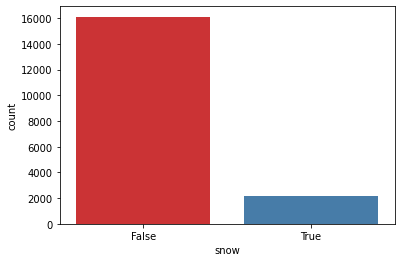

In [25]:
sns.countplot(x = 'snow', data = data_reindexed, palette='Set1');

Another variable that could be useful for our prediction is the seasonality of the weather. We can implement that by using the number of the week.

In [26]:
data = data_reindexed.reset_index()
data['weeknumber'] = data['date'].dt.week

In [27]:
data.head()

,station_number,date,mean_temp,mean_dew_point,mean_sealevel_pressure,mean_visibility,mean_wind_speed,max_sustained_wind_speed,max_temperature,total_precipitation,fog,rain,snow,hail,thunder,tornado,weeknumber
0,725326,2005-01-01,29.400000,20.100000,1025.400024,10.0,9.7,18.1,21.200001,0.00,False,False,False,False,False,False,53
1,725326,2005-01-02,38.700001,35.200001,1025.400024,6.9,8.0,16.9,32.000000,0.44,False,False,False,False,False,False,53
2,725326,2005-01-03,31.799999,28.200001,1025.400024,7.3,5.5,12.0,28.400000,0.11,False,False,False,False,False,False,1
3,725326,2005-01-04,28.799999,25.799999,1025.400024,6.3,6.1,11.1,28.400000,0.24,False,False,False,False,False,False,1
4,725326,2005-01-05,24.700001,20.799999,1025.400024,4.8,11.1,16.9,21.200001,0.01,False,False,False,False,False,False,1


Finally, check the correlation of our variables. We see that `mean_temp` and `mean_dew_point` are highly correlated. This makes sense since they the dew point is related to temperature. Similarly, `max_sustained_wind_speed` is related to `mean_wind_speed` and therefore also have, as expected, high correlation. We also see that the `fog`, `rain`, `hail`, `tornado` and `snow` variables are a 100% correlated. This, of course, will cause issues with our model since the dependent variables explain our independent variable, `snow`, 100%. Therefore, we will drop them from our dataset.

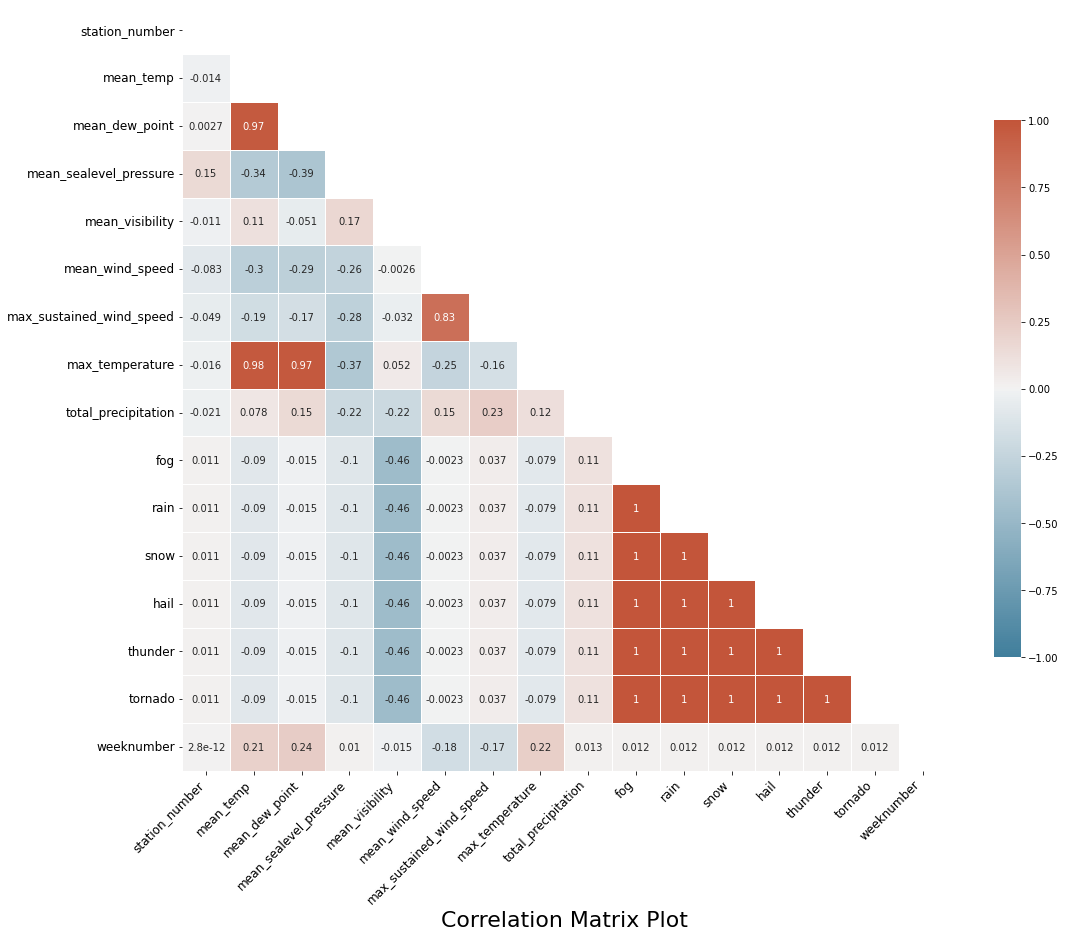

In [28]:
corr = data.corr()
cmap = cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
figure = plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, cmap = cmap, annot=True, square = True, mask = mask, linewidths=.5, 
            cbar_kws={"shrink": .5}, vmin=-1, vmax=1, center=0)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right', fontsize = 12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12)
plt.tight_layout()
plt.xlabel('Correlation Matrix Plot', fontsize = 22)
plt.show()

In [29]:
data = data.drop(columns = ['fog','rain','hail','thunder','tornado'])

### 3. Task
> Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for is the following, and hence should constitute your test set.

In [30]:
# The provided date does not account for leap years
# str(dt.datetime.tomorrow()- dt.timedelta(days=13*365)).split(' ')[0]

# Correct date
date_tomorrow_13_years_ago = dt.datetime.now() - relativedelta(years=13)
date_tomorrow_13_years_ago = str(date_tomorrow_13_years_ago + dt.timedelta(days=1)).split(' ')[0]
date_tomorrow_13_years_ago

# date_tomorrow_13_years_ago = '2009-07-05' # for future execution of the notebook

'2009-07-16'

Before we split the data into train and test set, we need to shift our dependent variable one day into the future since we want to predict if it will snow the next day based on the weather data of the current day. If we don't do this we are using the weather data of a day to predict if it will snow on that same day. This will cause one missing value per station for the starting date which we will remove to accomondate the needs of our models.

In [31]:
# Reindex on station_number and date to be able to shift the snow variable per station
data_clean = data.set_index(['station_number', 'date']).reindex(pd.MultiIndex.from_product(
        [data['station_number'].unique(), date_index],
        names=['station_number', 'date']))
# We shift the snow variable one day forward which will cause on NaN value at the starting date of each station
data_clean['snow'] = data_clean.snow.groupby(level = 'station_number').shift(1)
# Reset the index by station
data_clean = data_clean.reset_index()
# As expected the total number of NaN is 10, one per station
data_clean.snow.isna().sum()

10

In [32]:
# Remove the dates with NaNs 
data_clean = data_clean.dropna()

To split the data into training, evaluation and test set we will start with the test set. We create the test set and then remove the test set from our dataset to continue to the creation of the training and evaluation set. Next we use the `train_test_split` function from `sklearn` to create the train and evaluation/validation set with a train/validation split of 75/25. We can later adjust that according to our needs.

We also split the label from the data to accomondate the needs of our model.

#### Test set

In [33]:
X_test = data_clean.loc[data_clean['date'] == date_tomorrow_13_years_ago]

# Remove the test_set from our dataset
data_clean_without_test = data_clean.loc[data_clean['date'] != date_tomorrow_13_years_ago]

# Make date numeric so the model can handle it
X_test['date'] = pd.to_numeric(pd.to_datetime(X_test['date']))

# Separate label from test set
y_test=X_test.drop(X_test.columns.difference(['snow']), 1)
y_test = y_test.iloc[:,0]#.values                           # convert to series
X_test = X_test.drop(['snow'],axis=1)#.values

#### Train and Evaluation set

In [34]:
# Make date numeric so the model can handle it
data_clean_without_test['date'] = pd.to_numeric(pd.to_datetime(data_clean_without_test['date']))

# We will use the train_test_split function from sklearn to create the training and validation sets
# training set and evaluation set
X = data_clean_without_test.drop(['snow'],axis=1)#.values   # independent variables
y = data_clean_without_test['snow']#.values                 # dependent variable
y = y.astype('bool')

# We use a train/validation split of 75/25
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

Let's have a look at the dimensions of the train, evaluation and test sets we created.

In [35]:
print('X_train:')
print(X_train.shape)
print('y_train:')
print(y_train.shape)
print('X_valid:')
print(X_valid.shape)
print('y_valid:')
print(y_valid.shape)
print('X_test:')
print(X_test.shape)
print('y_test:')
print(y_test.shape)

X_train:
(13680, 11)
y_train:
(13680,)
X_valid:
(4560, 11)
y_valid:
(4560,)
X_test:
(10, 11)
y_test:
(10,)


## Part 2
> If you made it up to here all by yourself, you can use your prepared dataset to train an Algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [36]:
# The provided date does not account for leap years
# str(dt.datetime.tomorrow()- dt.timedelta(days=13*365)).split(' ')[0]

# Correct date
date_tomorrow_13_years_ago = dt.datetime.now() - relativedelta(years=13)
date_tomorrow_13_years_ago = str(date_tomorrow_13_years_ago + dt.timedelta(days=1)).split(' ')[0]
date_tomorrow_13_years_ago

# date_tomorrow_13_years_ago = '2009-07-05' # for future execution of the notebook

'2009-07-16'

> You are allowed to use any library you are comfortable with such as sklearn, tensorflow keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

Next, we will create a Random Forest Classifier. We can also use other methods for time series analysis like ARIMA, VAR models etc and compare their performance if the time was not limited.

In [37]:
# Create random forest classifier
model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)

#Train the model using the training sets
model.fit(X_train,y_train)

y_pred=model.predict(X_valid)

We see an accuracy of 0.88%. This is a fairly good performance but we need to keep in mind that the label data is not balanced.

In [38]:
print('Confusion matrix:')
print(confusion_matrix(y_valid,y_pred))
print('\nClassification report:')
print(classification_report(y_valid,y_pred))
print('Random Forest Accuracy:')
print(accuracy_score(y_valid, y_pred))

Confusion matrix:
[[3982    3]
 [ 557   18]]

Classification report:
              precision    recall  f1-score   support

       False       0.88      1.00      0.93      3985
        True       0.86      0.03      0.06       575

    accuracy                           0.88      4560
   macro avg       0.87      0.52      0.50      4560
weighted avg       0.87      0.88      0.82      4560

Random Forest Accuracy:
0.8771929824561403


In [39]:
column_names = X_train.columns # keep our column names for later

Our dataset is not scaled and this can cause issues if one variable has a range in the thousands and another in the tens. Our dataset does not suffer much from this issue since our ranges of our variables are relatively close. Moreover, scaling is not very important for the random forest algorithm. Despite that, we can implement scaling by using the `StandardScaler` from `sklearn` to scale our variables.

In [40]:
# Changes format of data and needs adjustments
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_valid = sc.transform(X_valid)

We saw before that our dataset label is not balanced and that the dates on which there was no snow are far more that with snow. This can cause a problem for our model since it will predict one class more often than the other. To tackle this issue, we can use different techniques like over sampling, under sampling, threshold and class weight. In our case we will go with under sampling of the prevalent since we have enough data, however, we could also investigate the effects the other techniques have on our model.

We can under sample our dataset manualy or we could use the `BalancedRandomForestClassifier` from the `imblearn` library shown below.

In [41]:
brf = BalancedRandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
brf.fit(X_train, y_train)

y_pred = brf.predict(X_valid)

Next, we have a look at the performance metrics of our model. We notice that the accuracy of our model has dropped a bit and is now 72%.

In [42]:
print('Confusion matrix:')
print(confusion_matrix(y_valid,y_pred))
print('\nClassification report:')
print(classification_report(y_valid,y_pred))
print('Balanced Random Forest Accuracy:')
print(accuracy_score(y_valid, y_pred))

Confusion matrix:
[[2893 1092]
 [ 197  378]]

Classification report:
              precision    recall  f1-score   support

       False       0.94      0.73      0.82      3985
        True       0.26      0.66      0.37       575

    accuracy                           0.72      4560
   macro avg       0.60      0.69      0.59      4560
weighted avg       0.85      0.72      0.76      4560

Balanced Random Forest Accuracy:
0.7173245614035088


We can take a look at the feature/variable importance of our dataset. We see that the `date` is almost twice as important as the second most important feature, `mean_visibility`. The rest of the important features also make logical sense.

After further research I found that this is not the best way to view the importance of the features. The preferred method would be to use [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance). This technique randomly shuffles one feature at a time to calculate the drop in model score, and thus find out how much the model depends on the shuffled feature. This method is also model agnostic and can be used to investigate the important features for each different model.

In [43]:
feature_imp = pd.Series(model.feature_importances_,index=column_names).sort_values(ascending=False)
feature_imp

date                        0.277776
mean_visibility             0.159036
mean_temp                   0.116881
total_precipitation         0.083301
station_number              0.077184
weeknumber                  0.067806
mean_sealevel_pressure      0.064330
max_temperature             0.055113
mean_dew_point              0.048818
mean_wind_speed             0.030889
max_sustained_wind_speed    0.018867
dtype: float64

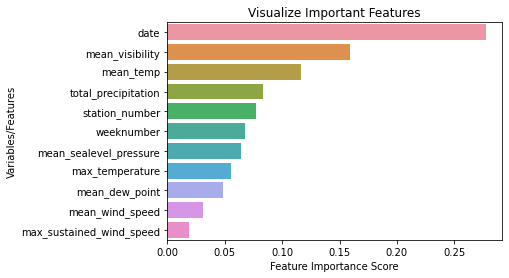

In [44]:
# Create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels
plt.xlabel('Feature Importance Score')
plt.ylabel('Variables/Features')
plt.title("Visualize Important Features")
plt.show()

Next, we balance the data again by under sampling the bigger dataset, to be able to use the train/validation sets for other models. We do this by using the `RandomUnderSampler` from `imblearn`.

In [45]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train.values, y_train.values)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_valid.values)}")

Training target statistics: Counter({False: 1571, True: 1571})
Testing target statistics: Counter({False: 3985, True: 575})


In [46]:
# Show that the data is balanced
pd.DataFrame(y_res).value_counts()

False    1571
True     1571
dtype: int64

From here on, we could make a function to automate the model training and testing, and fine tune different model hyperparameters while comparing the different models' performance (ROC Curves, AUC, lift curves, Precision-Recall Curves, etc). We also have to select a performance metric which would fit our needs and select the best model according to that metric.

### Experimentation

Below, I have experimented a bit with a LightGBM model.

In [47]:
# Build the lightgbm model with unbalanced data
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [48]:
# Predict the results
y_pred=clf.predict(X_valid)

In [49]:
# View accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_valid)
print('LightGBM Model accuracy score: {0:0.3f}'.format(accuracy_score(y_valid, y_pred)))

LightGBM Model accuracy score: 0.890


In [50]:
y_pred_train = clf.predict(X_train)

In [51]:
print('Training-set accuracy score: {0:0.3f}'.format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.930


In [52]:
# Print the scores on training and validation set

print('Training set score: {:.3f}'.format(clf.score(X_train, y_train)))
print('Validation set score: {:.3f}'.format(clf.score(X_valid, y_valid)))

Training set score: 0.930
Validation set score: 0.890


In [53]:
print('Confusion matrix:')
print(confusion_matrix(y_valid,y_pred))
print('\nClassification report:')
print(classification_report(y_valid,y_pred))
print('Accuracy Score:')
print(accuracy_score(y_valid, y_pred))

Confusion matrix:
[[3928   57]
 [ 444  131]]

Classification report:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94      3985
        True       0.70      0.23      0.34       575

    accuracy                           0.89      4560
   macro avg       0.80      0.61      0.64      4560
weighted avg       0.87      0.89      0.86      4560

Accuracy Score:
0.8901315789473684


In [54]:
# Build the lightgbm model with balanced data
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_res, y_res)

LGBMClassifier()

In [55]:
# Predict the results
y_pred=clf.predict(X_valid)

In [56]:
# View accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_valid)
print('LightGBM Model accuracy score: {0:0.3f}'.format(accuracy_score(y_valid, y_pred)))

LightGBM Model accuracy score: 0.725


In [57]:
y_pred_train = clf.predict(X_train)

In [58]:
print('Training-set accuracy score: {0:0.3f}'.format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.777


In [59]:
# Print the scores on training and validation set

print('Training set score: {:.3f}'.format(clf.score(X_train, y_train)))
print('Validation set score: {:.3f}'.format(clf.score(X_valid, y_valid)))

Training set score: 0.777
Validation set score: 0.725


In [60]:
print('Confusion matrix:')
print(confusion_matrix(y_valid,y_pred))
print('\nClassification report:')
print(classification_report(y_valid,y_pred))
print('Accuracy Score:')
print(accuracy_score(y_valid, y_pred))

Confusion matrix:
[[2874 1111]
 [ 145  430]]

Classification report:
              precision    recall  f1-score   support

       False       0.95      0.72      0.82      3985
        True       0.28      0.75      0.41       575

    accuracy                           0.72      4560
   macro avg       0.62      0.73      0.61      4560
weighted avg       0.87      0.72      0.77      4560

Accuracy Score:
0.724561403508772


### Final prediction

Finaly, we predict the requested test set, the date tomorrow 13 years ago. For all but one of our predicted days our model predicts correctly that it will not snow on the next day.

In [61]:
y_pred2 = brf.predict(X_test)
y_pred2

array([False,  True, False, False, False, False, False, False, False,
       False])

In [62]:
y_test = y_test.astype('bool')

In [63]:
print('Confusion matrix:')
print(confusion_matrix(y_test,y_pred2))
print('\nClassification report:')
print(classification_report(y_test,y_pred2))
print('Balanced Random Forest Accuracy:')
print(accuracy_score(y_test, y_pred2))

Confusion matrix:
[[9 1]
 [0 0]]

Classification report:
              precision    recall  f1-score   support

       False       1.00      0.90      0.95        10
        True       0.00      0.00      0.00         0

    accuracy                           0.90        10
   macro avg       0.50      0.45      0.47        10
weighted avg       1.00      0.90      0.95        10

Balanced Random Forest Accuracy:
0.9
